# Criação de Meta-Base

## Considerações sobre Aprendizado Ativo

Para que os experimentos sejam executados, é necessária a criação de uma meta-base a respeito do processo de **aprendizado ativo** (AL).  Contudo, algumas variáveis podem influenciar diretamente o processo de aprendizado ativo, sendo elas:

- Quantidade Inicial de Dados Rotulados (  $\vert X^0_{labeled}\vert$ )
- Quantidade de consultas a serem realizados ($q$)
- Estratégia de consulta utilizada (*query strategy*)
- Quantidade de instâncias retornadas por uma consulta (*batch size*)
- Método utilizado para ordenar as instâncias retornadas por uma consulta
- Tamanho do conjunto de teste para avaliar o aprendizado


### Quantidade Inicial de Dados Rotulados

Em tese, a ideia principal do AL é tentar popuar esforços de anotação ao rotular as instâncias que melhor descrevem um conjunto de dados. Dessa forma, na maioria dos casos lidamos com situações em que há uma pequena quantidade de instâncias rotuladas, apenas o suficiente para iniciar o processo de aprenzidado ativo

> Qual a quantidade ideal de dados anotados inicialmente? 

Como o nosso objetivo é simular várias configurações diferentes de active learning para cada uma das bases, é necessário pensar em alguma manera de deixar esse processo o mais reprodutível possível, algumas ideias são: 

1.  $\vert X_{labeled} \vert = n$, onde $n$ representa uma constante arbitrária
2.  $\vert X_{labeled} \vert = c$, onde $c$ representa o número de classes no problema de classificação
2.  $\vert X_{labeled} \vert = \alpha\times\vert X\vert$, onde $\alpha \in (0, 1]$ representa uma constante de proporcionalidade

### Quantidade de consultas a serem realizadas

Como a quantidade de instâncias varia conforme o conjunto de dados, também devemos decidir como escolheremos esse parâmetro. Dessa forma podemos utilizar soluções similares às citadas acima, porém baseado no tamanho do conjunto de dados

### Estratégia de Consulta

Estratégias baseadas na incerteza de um classificador:
- [ ] Classification Uncertainty 
- [ ] Classification Margin
- [ ] Classification Entropy


Estratégias baseadas em discordância entre modelos

- [ ] Vote Entropy
- [ ] Consensus Entropy
- [ ] Max Disagreement

### Quantidade de instâncias retornadas por consulta

Originalmente, as estratégias de consulta está preocupadas em selecionar a instância mais interessante para ser rotulado, contudo o que ocorre geralmente é que o anotador não está disposto a anotar apenas uma instância e esperar uma próxima iteração do processo de AL ser executado novamente. Muito tempo e recursos podem ser otimizados se mais de uma instância for retornada por consulta.

Todavia, simplesmente retornar as $n$ consultas com a maior pontuação, pode não ser uma boa ideia (embora as vezes seja uma alternativa). Sendo assim Cardoso et. al formularam uma maneira de ranquear essas instâncias

$score = \alpha(1 - \Phi(x, X_{labeled})) + (1 - \alpha) U(x),$ 

Onde $\alpha = \frac{|X_{unlabeled}|}{|X_{unlabeled}| + |X_{labeled}|}$, $U(x)$ é a incerteza das predições para $x$ e $\Phi$ é uma função de similaridade. Dessa forma é possível medir o quão bem o espaço de características foi explorado perto de $x$

## Criação de Meta-base

### Simulação de Cenário

In [142]:
import os
import warnings
from typing import Union
from functools import partial

from modAL import ActiveLearner
from pymfe.mfe import MFE
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.exceptions import ConvergenceWarning
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np
import openml
import pandas as pd





class ActiveLearningSimulator:
    def __init__(self, dataset:openml.datasets.OpenMLDataset, test_size=None):

        self.dataset = dataset

        X, y, categorical_indicator, _ = dataset.get_data(
            target=dataset.default_target_attribute)
        
        encoder = OneHotEncoder(handle_unknown='ignore')

        transformers = [('one-hot-encoder', encoder, categorical_indicator)]
        
        preprocessor = ColumnTransformer(transformers, remainder='passthrough')

        self.X = preprocessor.fit_transform(X)
        self.y = y.to_numpy()

        X_train, X_test, y_train, y_test = train_test_split(
            self.X, self.y, stratify=y, test_size=test_size)
            
        self.training_index = self.gen_initial_training_index(y_train)

        self.X_train, self.y_train = X_train, y_train
        self.X_test, self.y_test = X_test, y_test

        self.results_path = f'{dataset.id}_{dataset.name}'
        
        try:
            os.mkdir(self.results_path)
        except FileExistsError:
            pass
            
    def gen_initial_training_index(self, y):
        return [np.random.choice(np.where(y == cls)[0])
                for cls in np.unique(y)]
            
    def run(self, model, query_strategy, num_queries: int, batch_size: int = 1, extract_mf=True, plot_result=True):

        warnings.simplefilter(action='ignore', category=ConvergenceWarning)

        X_training = self.X_train[self.training_index]
        y_training = self.y_train[self.training_index]

        X_pool = np.delete(self.X_train, self.training_index, axis=0)
        y_pool = np.delete(self.y_train, self.training_index, axis=0)
        
        learner = ActiveLearner(
            estimator=model,
            query_strategy=partial(query_strategy, n_instances=batch_size),
            X_training=X_training,
            y_training=y_training)

        y_pred = learner.predict(self.X_test)
        unqueried_score = classification_report(y_pred, self.y_test, output_dict=True, zero_division=0)
        performance_history = [unqueried_score]
        
        pbar = tqdm(range(num_queries), leave=False)
        for i in pbar:
            pbar.set_description(
                desc=f'{type(model).__name__, query_strategy.__name__}',
                refresh=True)

            mfs = (self.extract_mf(X_pool, y_pool, supress_warnings=True) 
                   if extract_mf else dict())
            
            query_index, query_instance = learner.query(X_pool)
            learner.teach(X=X_pool[query_index], y=y_pool[query_index])

            X_pool = np.delete(X_pool, query_index, axis=0)
            y_pool = np.delete(y_pool, query_index, axis=0)

            y_pred = learner.predict(self.X_test)
            model_score = classification_report(y_pred, self.y_test, output_dict=True, zero_division=0)
            performance_history.append(model_score)
            
            pbar.set_postfix(
                U=len(X_pool),
                L=len(learner.X_training),
                accuracy=model_score['accuracy'],
                f1_score=model_score['weighted avg']['f1-score'],
                refresh=True)

            self.save_mf(i, mfs, model_score, 
                        model=model,
                        query_strategy=query_strategy,
                        num_queries=num_queries,
                        batch_size=batch_size)
        pbar.close()

        if plot_result:
            self.plot_result(performance_history)
            
        return performance_history

    def extract_mf(self, X, y, supress_warnings=False):
        with warnings.catch_warnings():
            if supress_warnings:
                warnings.simplefilter("ignore")
            extractor = MFE(groups='all') 
            extractor.fit(X, y, supress_warnings=supress_warnings)
            results = extractor.extract(suppress_warnings=supress_warnings)

        record = {k: v for k, v in zip(*results)}
        return record
        
    def save_mf(self, q_number, metafeatures, scores, **kwargs):
        df = pd.DataFrame.from_records([metafeatures])
        df['accuracy'] = scores['accuracy']
        df['f1-macro'] = scores['macro avg']['f1-score']
        df['f1-weighted'] = scores['weighted avg']['f1-score']
        df['query_number'] = q_number

        df.set_index('query_number', inplace=True)
        
        model = type(kwargs['model']).__name__
        q_strategy = kwargs['query_strategy'].__name__
        n_queries = kwargs['num_queries']
        batch_size = kwargs['batch_size']
        
        file_name = f'{model}_{q_strategy}_{n_queries}_{batch_size}.csv'

        file_path = os.path.join(self.results_path, file_name)
        
        df.to_csv(file_path, mode='a', header=not os.path.exists(file_path))

    def plot_result(self, performance_history):
        df = pd.DataFrame.from_records([e['weighted avg'] for e in performance_history])
        df['accuracy'] = [e['accuracy'] for e in performance_history]
        
        df.drop(columns=['support'], inplace=True)
        
        df.plot(subplots=True, layout=(2,2), grid=True,
                title = f"Performance x Query ({dataset.qualities['NumberOfClasses']} classes)",
                ylim=(0,1))
        
        plt.show()

Instanciação de base exemplo

In [94]:
from config import dataset_ids

dataset = openml.datasets.get_dataset(dataset_ids[0])

/tmp/ipykernel_720803/3011865225.py:3: FutureWarning: Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `download_qualities`, and `download_features_meta_data` to a bool while calling `get_dataset`.
  dataset = openml.datasets.get_dataset(dataset_ids[0])


Testando configuração

Automatic pdb calling has been turned OFF


  0%|          | 0/100 [00:00<?, ?it/s]

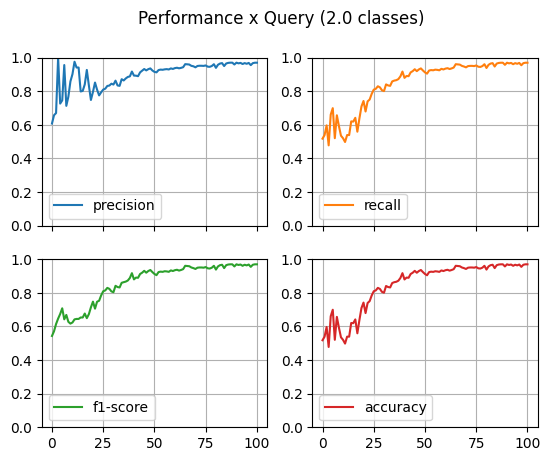

In [115]:
%pdb 0
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from modAL.uncertainty import uncertainty_sampling
from modAL.batch import uncertainty_batch_sampling



simulator = ActiveLearningSimulator(dataset)

performance_history = simulator.run(model=SVC(probability=True),
                                    query_strategy=uncertainty_sampling,
                                    num_queries=100,batch_size=2)

### Definindo Cenários

#### Classificadores

In [136]:
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

class SVCLinear(SVC):
    pass
    
clf_list = [SVCLinear(kernel='linear', probability=True),
            SVC(probability=True),
            RandomForestClassifier(),
            KNeighborsClassifier(
                n_neighbors=int(dataset.qualities["NumberOfClasses"])),
            MLPClassifier(),
            LogisticRegression(),
            DecisionTreeClassifier(),
            GaussianNB(),
]

#### Estratégias de consulta

In [127]:
from modAL.uncertainty import uncertainty_sampling, margin_sampling, entropy_sampling
from modAL.batch import uncertainty_batch_sampling

query_strategies = [ 
    uncertainty_sampling,
    uncertainty_batch_sampling, 
    margin_sampling,
    entropy_sampling
]

#### Teste

In [ ]:
simulator = ActiveLearningSimulator(dataset)

for query_strategy in query_strategies:
    for clf in clf_list:
        simulator.run(model=clf,
                      query_strategy=query_strategy,
                      num_queries=20,
                      batch_size=5,
                      extract_mf=False,plot_result=False)
                      

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]